In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

class vector2D:
    def __init__(self, x = 0, y = 0):
        self.x = x
        self.y = y
        
    def __str__(self):
        return "({:.3f}, {:.3f})".format(self.x, self.y)
    
    def multiply(self, c):
        return vector2D(self.x * c, self.y * c)
    
    def divide(self, c):
        return vector2D(self.x / c, self.y / c)
    
    def add(self, v):
        return vector2D(self.x + v.x, self.y + v.y)
    
    def lenght_square(self):
        return self.x ** 2 + self.y ** 2
    
    def product(self, v):
        return self.x * v.x + self.y * v.y

class particle:
    def __init__(self, position = vector2D(0, 10), velocity = vector2D()):
        self.position = position
        self.velocity = velocity
        #self.mass = mass
        #mass is always 1
        
    def __str__(self):
        return "Position: {}, Velocity: {}, Mass: {}".format(self.position, self.velocity, self.mass)
    
    def PrintPosition(self):
        print("Position: {}".format(self.position))
    
    def move(self, force):
        global dt
        tmp = particle(self.position, self.velocity)
        tmp.velocity = tmp.velocity.add(force.multiply(dt))
        tmp.position = tmp.position.add(tmp.velocity.multiply(dt))
        #need to correct this part
        if tmp.position.y <= 0:
            tmp.position.y *= -1
            tmp.velocity.y *= -1 
        return tmp
    
class polygon:
    def __init__(self,
                 points = [vector2D(0, 1), vector2D(1, 0), vector2D()],
                 velocity = vector2D(),
                 angular_velocity = 0):
        self.points = points
        self.center = centroid(points)
        self.velocity = velocity
        self.angular_velocity = angular_velocity
        self.n = len(points)
        
    def __str__(self):
        str = "{} sided polygon\nPoints: {}".format(self.n, self.points[0])
        for i in range(1, self.n):
            str += ", {}".format(self.points[i])
        return str
    
    def display(self):
        x, y = [], []
        for i in range(self.n):
            x.append(self.points[i].x)
            y.append(self.points[i].y)
        plt.fill(x, y)
        plt.axis('equal')
        plt.axis([-2,5,0,4])
        plt.show()
        
    def save_display(self, num):
        x, y = [], []
        for i in range(self.n):
            x.append(self.points[i].x)
            y.append(self.points[i].y)
        plt.fill(x, y)
        plt.axis('equal')
        plt.axis([-2,5,0,4])
        plt.savefig("img_seq\{}.png".format(num))
        plt.clf()
    
    #only move
    #velocity remains the same
    def move(self):
        global dt
        tmp = polygon(self.points, self.velocity, self.angular_velocity)
        a, b = tmp.velocity.x * dt, tmp.velocity.y * dt
        move = np.matrix([[1, 0, a],
                          [0, 1, b],
                          [0, 0, 1]])
        for i in range(tmp.n):
            p = np.matrix([[tmp.points[i].x], [tmp.points[i].y], [1]])
            new_p = move * p
            tmp.points[i] = vector2D(new_p[0, 0], new_p[1, 0])
        tmp.center = centroid(tmp.points)
        return tmp

    def move_manual(self, v):
        tmp = polygon(self.points, self.velocity, self.angular_velocity)
        move = np.matrix([[1, 0, v.x],
                          [0, 1, v.y],
                          [0, 0, 1]])
        for i in range(tmp.n):
            p = np.matrix([[tmp.points[i].x], [tmp.points[i].y], [1]])
            new_p = move * p
            tmp.points[i] = vector2D(new_p[0, 0], new_p[1, 0])
        tmp.center = centroid(tmp.points)
        return tmp
    
    #only rotate
    #angular velocity remains the same
    def rotate(self):
        global dt
        tmp = polygon(self.points, self.velocity, self.angular_velocity)
        d_alpha = tmp.angular_velocity * dt
        s = math.sin(d_alpha)
        c = math.cos(d_alpha)
        rotation = np.matrix([[c,-s, 0],
                              [s, c, 0],
                              [0, 0, 1]])
        move1 = np.matrix([[1, 0, -tmp.center.x],
                           [0, 1, -tmp.center.y],
                           [0, 0, 1]])
        move2 = np.matrix([[1, 0, tmp.center.x],
                           [0, 1, tmp.center.y],
                           [0, 0, 1]])
        for i in range(tmp.n):
            p = np.matrix([[tmp.points[i].x], [tmp.points[i].y], [1]])
            new_p = move2 * rotation * move1 * p
            tmp.points[i] = vector2D(new_p[0, 0], new_p[1, 0])
        
        
        return tmp
    
    def rotate_manual(self, alpha):
        tmp = polygon(self.points, self.velocity, self.angular_velocity)
        s = math.sin(alpha)
        c = math.cos(alpha)
        rotation = np.matrix([[c,-s, 0],
                              [s, c, 0],
                              [0, 0, 1]])
        move1 = np.matrix([[1, 0, -tmp.center.x],
                           [0, 1, -tmp.center.y],
                           [0, 0, 1]])
        move2 = np.matrix([[1, 0, tmp.center.x],
                           [0, 1, tmp.center.y],
                           [0, 0, 1]])
        for i in range(tmp.n):
            p = np.matrix([[tmp.points[i].x], [tmp.points[i].y], [1]])
            new_p = move2 * rotation * move1 * p
            tmp.points[i] = vector2D(new_p[0, 0], new_p[1, 0])
        return tmp
    
    #detect collision
    #change velocity and angular velocity
    def detect_collision(self):
        global dt
        global force
        tmp = polygon(self.points, self.velocity, self.angular_velocity)
        tmp.velocity = tmp.velocity.add(force.multiply(dt))
        
        min_y = tmp.points[0].y
        for i in range(2, tmp.n):
            if tmp.points[i].y < min_y:
                min_y = tmp.points[i].y
        if min_y < 0:
            tmp = tmp.move_manual(vector2D(0, -min_y))
            print("collision!")
        
        coll_points = []
        for i in range(tmp.n):
            if tmp.points[i].y <= 0:
                coll_points.append(i)
        if len(coll_points) == 1:
            #vector from center to the point of contact
            cp = tmp.points[coll_points[0]].add(tmp.center.multiply(-1))
            
            #tolal velocity in the point of contact
            pv = vector2D(tmp.velocity.x - cp.y * tmp.angular_velocity, tmp.velocity.y + cp.x * tmp.angular_velocity)
            
            #impulse
            J = vector2D(-pv.x, -pv.y)
            
            #set velocity and angular velocity
            tmp.velocity = tmp.velocity.add(J)
            tmp.angular_velocity += J.product(cp) / cp.lenght_square()
        
        if len(coll_points) == 2: #???
            point = tmp.points[coll_points[0]].add(tmp.points[coll_points[1]])
            point = point.multiply(0.5)
            
            #vector from center to the point of contact
            cp = point.add(tmp.center.multiply(-1))
            
            #tolal velocity in the point of contact
            pv = vector2D(tmp.velocity.x - cp.y * tmp.angular_velocity, tmp.velocity.y + cp.x * tmp.angular_velocity)
            
            #impulse
            J = vector2D(-pv.x, -pv.y)
            
            #set velocity and angular velocity
            tmp.velocity = tmp.velocity.add(J)
            tmp.angular_velocity += J.product(cp) / cp.lenght_square()
        return tmp
            

In [2]:
#signed area
def area(points):
    n = len(points)
    points.append(points[0])
    A = 0
    for i in range(n):
        A += points[i].x * points[i + 1].y - points[i + 1].x * points[i].y
    A /= 2
    points.pop()
    return A

#calculate centroid
def centroid(points):
    n = len(points)
    points.append(points[0])
    c = vector2D()
    A = area(points)
    for i in range(n):
        c.x += (points[i].x + points[i + 1].x) * (points[i].x * points[i + 1].y - points[i + 1].x * points[i].y)
        c.y += (points[i].y + points[i + 1].y) * (points[i].x * points[i + 1].y - points[i + 1].x * points[i].y)
    c = c.divide(6 * A)
    points.pop()
    return c

In [3]:
force = vector2D(0, -9.81)
dt = 0.01

In [ ]:
a = particle(vector2D(0, 10), vector2D(1, 0))

#multiple iteration over time on particle
a.PrintPosition()
current_time = 0
while current_time < 2:
    a = a.move(force)
    a.PrintPosition()
    current_time += dt

In [ ]:
points = [vector2D(-1, 3), vector2D(3, -1), vector2D(-3, -1), vector2D(-3, 2)]
p = polygon(points = points, velocity = vector2D(0, 1))
print(p.center)
p = p.move()
print(p.center)

In [ ]:
points = [vector2D(), vector2D(1, 2), vector2D(2, 1)]
p = polygon(points = points, angular_velocity = math.pi / 2)
p.display()
p = p.rotate()
p.display()

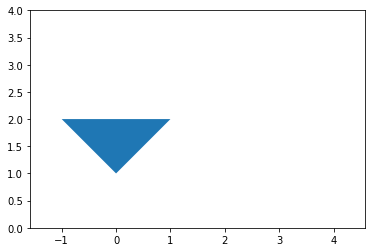

In [4]:
#create test object
#points = [vector2D(-1.5, 1), vector2D(-0.5, 3), vector2D(0.5, 2)]
points = [vector2D(-1, 2), vector2D(1, 2), vector2D(0, 1)]
p = polygon(points = points)
p = p.detect_collision()
p.display()

In [ ]:
p = p.rotate() 
p = p.move()
p = p.detect_collision()
print(p)
print("Velocity: {}, Angular: {:.3f}, Center: {}".format(p.velocity, p.angular_velocity, p.center))
p.display()

In [5]:
for frame in range(0, 200):
    #order matters!!!
    p = p.rotate() 
    p = p.move()
    p = p.detect_collision()
    #p.display()
    p.save_display(frame)
    #print("{}: Velocity: {}, Angular: {:.3f}, Center: {}".format(frame, p.velocity, p.angular_velocity, p.center))

collision!
collision!
collision!


<Figure size 432x288 with 0 Axes>

In [6]:
print(p)

3 sided polygon
Points: (6.148, 2.678), (4.433, 3.706), (5.805, 4.050)
